<a href="https://colab.research.google.com/github/wooridle/mlp_lecture/blob/main/9.mnist_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

## MNIST 데이터 셋

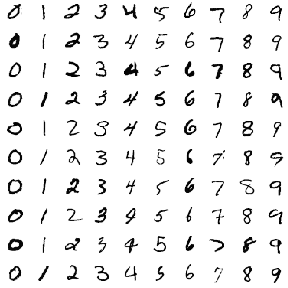

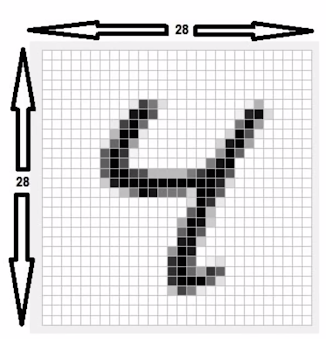

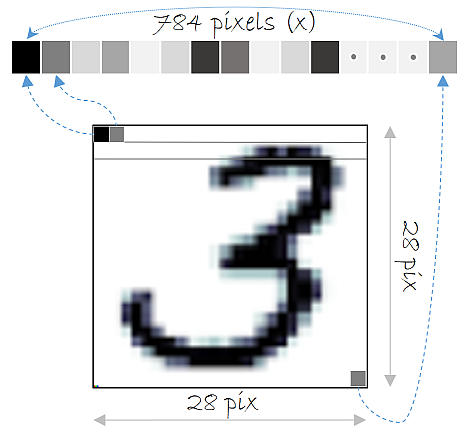

# Load and Visualize the Data


### Reference : https://github.com/iam-mhaseeb/Multi-Layer-Perceptron-MNIST-with-PyTorch/blob/master/mnist_mlp_exercise.ipynb


### number of subprocesses to use for data loading
num_workers = 0
### how many samples per batch to load
batch_size = 20

### convert data to torch.FloatTensor
transform = transforms.ToTensor()

### choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

### prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# Visualize a Batch of Training Data

import matplotlib.pyplot as plt
%matplotlib inline
    
#### obtain one batch of training images
dataiter = iter(train_loader)

images, labels = dataiter.next()

images = images.numpy()

#### plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):

    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])

    ax.imshow(np.squeeze(images[idx]), cmap='gray')

    # print out the correct label for each image

    # .item() gets the value contained in a Tensor
    
    ax.set_title(str(labels[idx].item()))

# View an Image in More Detail

img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 

ax = fig.add_subplot(111)

ax.imshow(img, cmap='gray')

width, height = img.shape

thresh = img.max()/2.5

for x in range(width):

    for y in range(height):

        val = round(img[x][y],2) if img[x][y] !=0 else 0

        ax.annotate(str(val), xy=(y,x),

                    horizontalalignment='center',

                    verticalalignment='center',
                    
                    color='white' if img[x][y]<thresh else 'black')

# Define the Network Architecture

import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture

class Net(nn.Module):

    def __init__(self):

        super(Net, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 512)

        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)

        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

#### initialize the NN
model = Net()

print(model)

# Specify Loss Function and Optimizer

#### Specify loss and optimization functions

#### specify loss function
criterion = nn.CrossEntropyLoss()

#### specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the Network

# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

# Test the Trained Network


#### initialize lists to monitor test loss and accuracy
test_loss = 0.0

class_correct = list(0. for i in range(10))

class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss

test_loss = test_loss/len(test_loader.dataset)

print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):

    if class_total[i] > 0:

        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

    else:

        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (

    100. * np.sum(class_correct) / np.sum(class_total),
    
    np.sum(class_correct), np.sum(class_total)))

# Visualize Sample Test Results

#### obtain one batch of test images

dataiter = iter(test_loader)

images, labels = dataiter.next()

#### get sample outputs

output = model(images)

#### convert output probabilities to predicted class

_, preds = torch.max(output, 1)

#### prep images for display

images = images.numpy()

#### plot the images in the batch, along with predicted and true labels

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):

    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])

    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),

                 color=("green" if preds[idx]==labels[idx] else "red"))